In [1]:
%run setup
%load_ext autoreload
%autoreload 2

In [29]:
from IPython.display import Image
from pathlib import Path
from nlp_intro.data import draw_uniform_data
from nlp_intro.figure_factory import Linear2D2ClassModelPlotter, plot_3d_scatter, gradient_descent_animation
import pandas as pd
import numpy as np
from nlp_intro.logistic_regression import gradient
from nlp_intro.data import load_diskusjon_no_data
import re

In [3]:
root_dir = Path("..").resolve()

# Mål for presentasjonen

- Kommer ikke til å gå i dybden på hver algoritme som brukes - flere av algoritmene kunne vi dedikert en helt egen fagkveld til
- Målet med presentasjonen er å:
    - Demystifisere NLP - gi deg en forståelse av hvordan ulike NLP-problemstillinger løses
    - Gi en praktisk introduksjon til temaet gjennom kode

# Maskinlæring på 5 minutter

# 2 typer maskinlæring

1. **Veiledet læring** (en: supervised learning): metoder for å lære seg en sammenheng mellom data og kategorier/tallverdier tillordnet denne dataen, slik at man gitt ny data kan predikere disse kategoriene/tallverdiene

2. **Ikke-veiledet læring** (en: unsupervised learning): metoder for å finne nyttige mønstre i data

 ## Veiledet læring

 
<center> <img src="../images/bender.gif"/> </center>

Vi har datapunkter $X$ og for hvert datapunkt en kategori/tallverdi $y$. Vi antar at det er en sammenheng mellom $X$ og $y$, slik at $X$ kan brukes for å predikere $y$:
$$X \rightarrow y$$

Ved hjelp av *veiledet læring* ønsker vi å finne denne "pilen"/modellen:
$$X \boxed{\rightarrow} y$$

..slik at gitt nye datapunkter $X_2$ og modellen:
$$X_2 \rightarrow $$

...kan vi produsere prediksjoner for hvert av de nye datapunktene:
$$X_2 \rightarrow y_2$$

## Eksempel: et datasett av bokser

<center> <img src="../images/boxes1.png"  style="height:200px;width:auto;"/> </center>

In [34]:
data = draw_uniform_data(100, (0, 1), (0, 1))
feature_names = ("width", "height")
pd.DataFrame(data, columns=feature_names).head(3)

,width,height
0,0.207300,0.258934
1,0.785209,0.880128
2,0.011815,0.195721


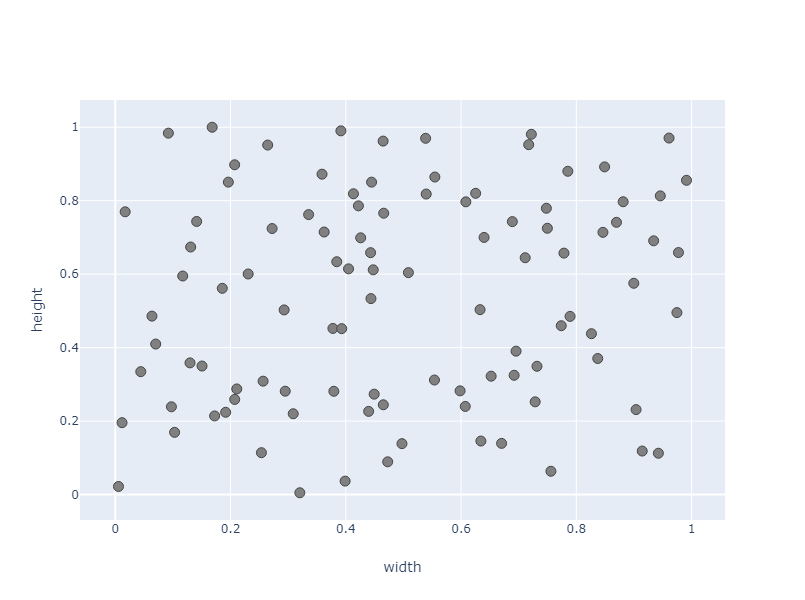

In [35]:
layout = dict(width=800, height=600, yaxis=dict(title_text="height"), xaxis=dict(title_text="width"))
plotter = Linear2D2ClassModelPlotter((0,1), (0,1), layout=layout)
plotter.update_data_plots(data)
plotter()

### En lineær modell for boks-dataen

Er dette en god modell for boks-dataen vår?

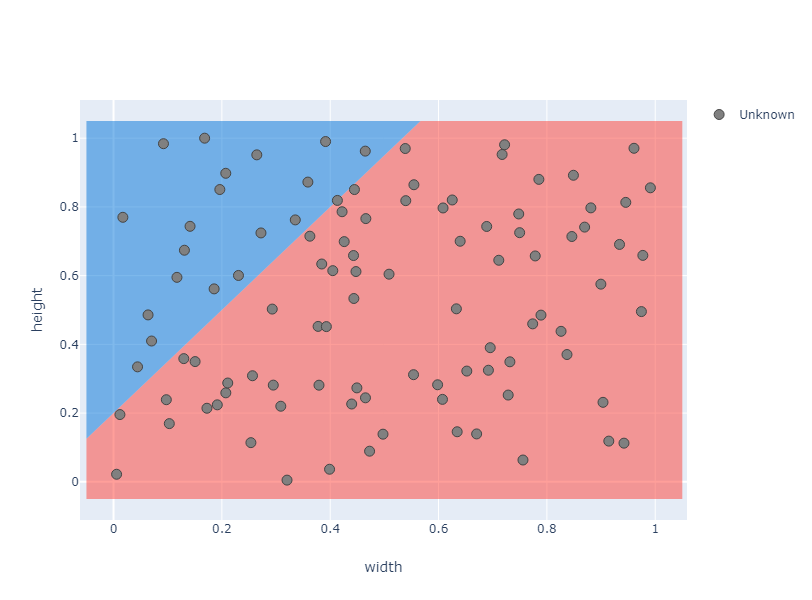

In [38]:
plotter.update_model_area_plots(lambda x: 1.5*x+0.2)
plotter()

Umulig å vite. For å kunne en veiledet modell trenger vi noe som kan veilede modellen.

In [39]:
def predict(boolean_model, data, class_names):
    label_ids = boolean_model(data)
    label_names = np.asarray(class_names)
    return label_names[label_ids.astype(int)]

### Tagging av hvert datapunkt

- For å veilede modellen vår må hvert punkt tagges med en kategori eller tallverdi.
- Mange potensielle måter å tagge boks-datapunktene våre, men én mulighet er å skille mellom "vide" og "høye" rektangler

<center> <img src="../images/rectangle-classes.png"  style="height:600px;width:auto;"/> </center>

Obs: dette er *ikke* et problem som bør løses med maskinlæring, men det lar seg fint gjøre om man har samlet data med disse taggene

Vi vil da få et datasett på følgende format:

In [50]:
class_names = ["Tall rectangle", "Wide rectangle"]
model = lambda data: data[:,0] > data[:,1]
labels = predict(model, data, class_names)
pd.DataFrame(np.asarray([*data.T, labels]).T, columns=("width", "height", "class")).head(5)

,width,height,class
0,0.20729979472648374,0.25893447150629323,Tall rectangle
1,0.7852087214162017,0.8801282601490411,Tall rectangle
2,0.011815321573685478,0.19572097934214994,Tall rectangle
3,0.25361835400399335,0.11398602427303439,Wide rectangle
4,0.39147726744087674,0.9902341168393478,Tall rectangle


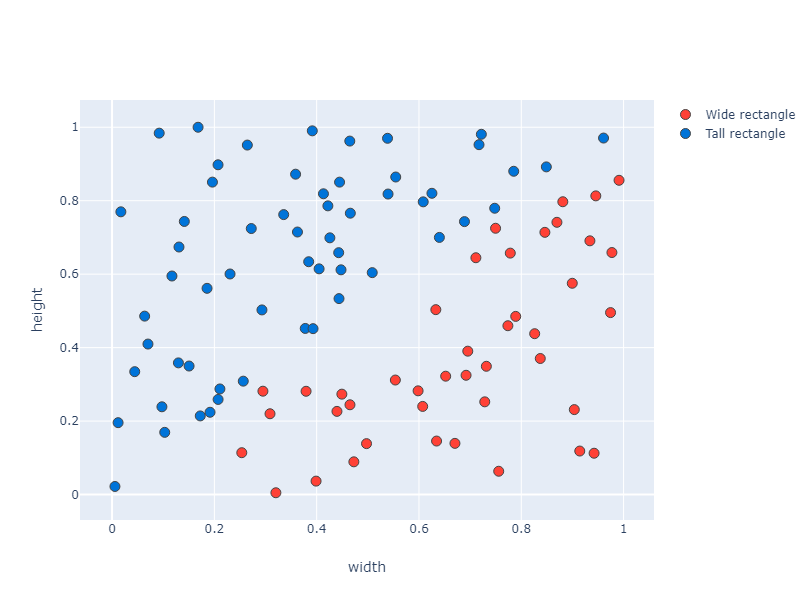

In [51]:
plotter.disable_model_areas()
plotter.update_data_plots(data, labels, unq_classes=class_names[::-1])
plotter()

### En lineær modell for å skille mellom vide og høye rektangler

For å skille disse punktene fra hverandre kan vi trene en lineær modell vha veiledet læring. Kan vi nå si om modellen er god eller ikke?

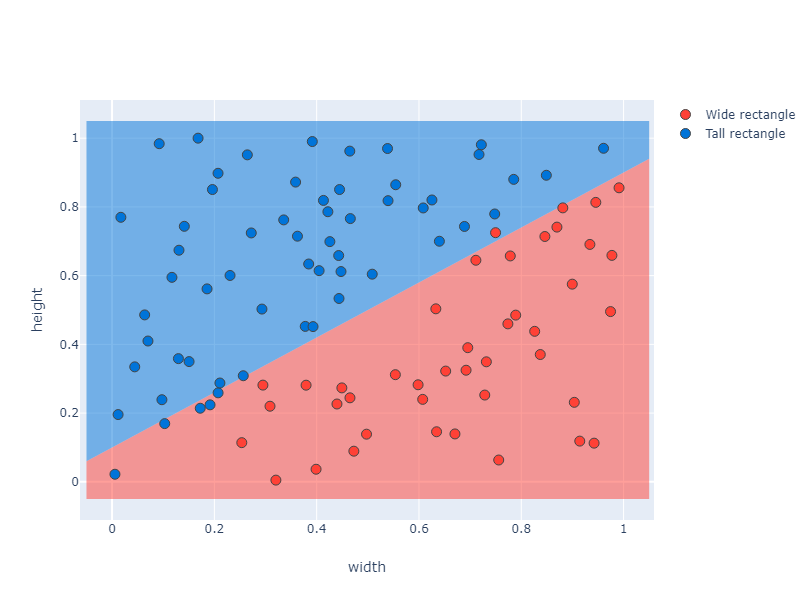

In [54]:
lin_model = lambda x: 0.8*x + 0.1
plotter.enable_model_areas()
plotter.update_model_area_plots(lin_model)
plotter()

Ja, vi kan nå bruke kategoriene i datasettet vårt for å avgjøre om modellen er god eller om den må justeres.

Med en trent modell kan vi gjøre prediksjoner for nye datapunkter. Vi kan da "kaste vekk" all dataen vi brukte for å trene den.

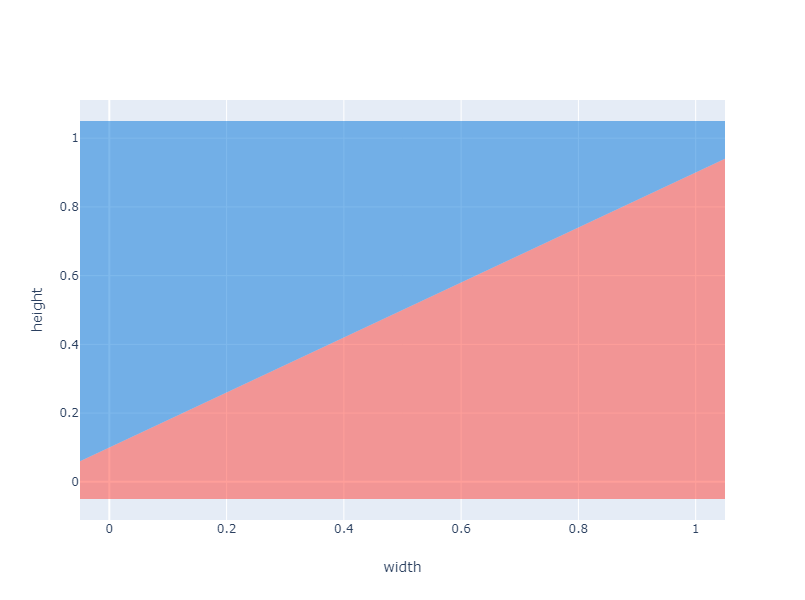

In [56]:
plotter.disable_data_points()
plotter()

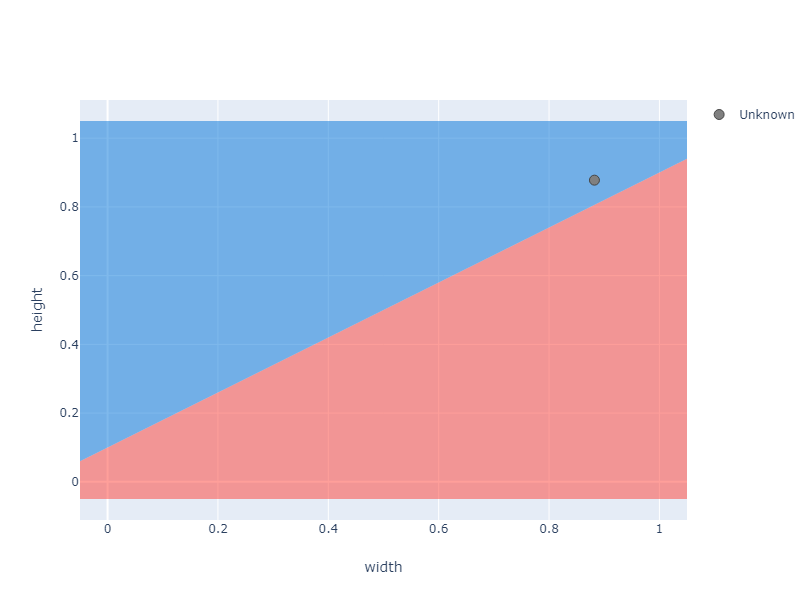

In [57]:
new_data = draw_uniform_data(1, (0,1), (0,1))
plotter.update_data_plots(new_data)
plotter.enable_data_points()
plotter()

In [58]:
def predict_using_linear_model(lin_model, data, class_names):
    label_ids = (lin_model(data[:,0]) > data[:,1]).astype(int)
    return np.asarray(class_names)[label_ids]

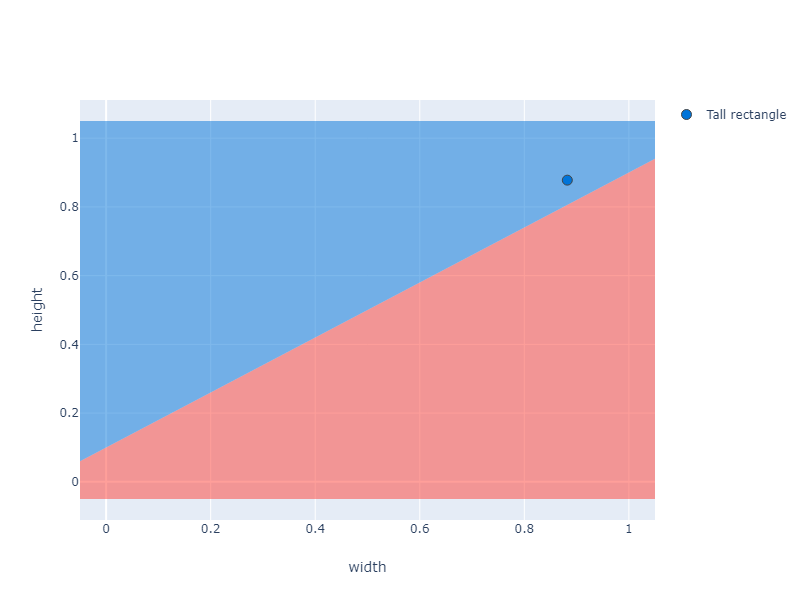

In [59]:
labels = predict_using_linear_model(lin_model, new_data, class_names)
plotter.update_data_plots(new_data, labels, unq_classes=class_names[::-1])
plotter()

## Hvordan forbedre modellen?

For å finne ut hvordan modellen må endres kan vi definere en *feilfunkson* $E$ og bruke de deriverte av denne funksjonen mht parametere i modellen vår. Den deriverte for en parameter vil peke i retningen vi må endre parameteren for å redusere verdien av feilfunksjonen.

$$
\frac{\partial}{\partial w_i}E(modell, data, klasser)
$$
Hvor modellen er en funksjon av $w_0, w_1,...,w_n$

Link til presentasjon

### Psuedo-algoritme for veiledet læring ved "gradient descent" 

1. Start med en tilfeldig konfigurasjon av modellen
2. Beregn de deriverte (aka gradientene, derav "gradient descent")
3. Bruk disse for å oppdatere modellen
4. Iterer steg 1-3 frem til endringene av modellen fra et steg til det neste blir for små (eller et annet stopp-kriterium er nådd)

<center> <img src="../images/gradient-descent.jpg"/> </center>

La oss teste dette opp boks-dataen vår. Vi vet at den korrekte linjen for å skille høye og vide rektangler vil være:
$$y = w_0*x + w_1 = 1 * x + 0 = x$$

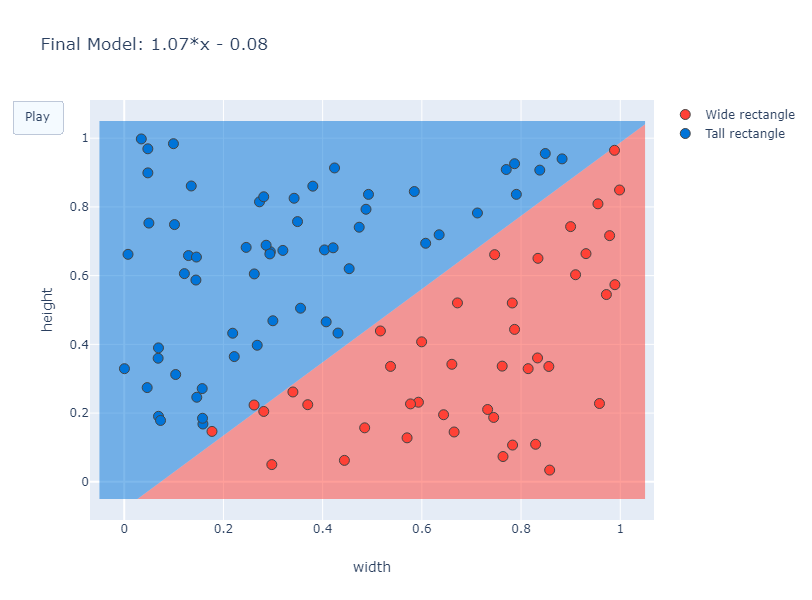

In [244]:
gradient_descent_animation((0, 1), (0, 1), w_real=[1, -1, 0], w_initial=[-0.5, -1, 0.8], lr=1, layout=layout, class_names=class_names, inv_class_names_for_plot=True)

# Ikke-veiledet læring

# Skaffe data

- Wikipedia
- Twitter
- Nyheter

# Wikiextractor

# BeautifulSoup

# Fra tekst til tall

- Alle maskinlæringsmodeller bruker matematikk/statistikk for å finne optimal konfigurasjon
- For å kunne bruke maskinlæring for NLP er vi derfor nødt til å konvertere tekstene til tall
- Mange måter å gjøre dette på:
    - Bag-of-words (BOW)
    - BOW + TF-IDF
    - N-grams (+ TF-IDF)
    - Char n-grams (+ TF-IDF)
    - Word embeddings (word2vec, Glove, fastText)
    - Document embeddings (doc2vec, min/max/mean pooling, RNN encoder)
    - Contextualized word embeddings (ELMO, BERT, Flair)

## Bag-of-words (BOW)

- Tell antall forekomster av hvert enkelt ord, og lag én kolonne per ord
- Hva er et ord? Standard definisjon er som regel "en sammenhengende sekvens av alfanumeriske (a-z, 0-9, _) karakterer"

In [202]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer()
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,en,er,funker,håper,tekst
0,1,1,1,0,0,1
1,1,0,0,1,1,0


In [11]:
print(texts_vec)

  (0, 0)	1
  (0, 2)	1
  (0, 1)	1
  (0, 5)	1
  (1, 0)	1
  (1, 4)	1
  (1, 3)	1


Alternativt ord-mønster:

In [12]:
vec2 = CountVectorizer(token_pattern="(?:\w+|[^\w\s]+)")
texts_vec2 = vec2.fit_transform(texts)
pd.DataFrame(texts_vec2.todense(), columns=vec2.get_feature_names())

,!,:),dette,en,er,funker,håper,tekst
0,1,0,1,1,1,0,0,1
1,0,1,1,0,0,1,1,0


Tips:
- Jobber du med et domene du kjenner, eller domene-eksperter - bruk kunnskapen din til å forbedre ord-mønsteret ditt.
- F.eks. vil smileys muligens være nyttig å hente ut som egne ord om du bygger en sentiment-klassifiserer.

# "TF-IDF"-vekting av ord
- **TF** (Term frequency): Antall ganger ordet oppstår i en bestemt tekst
- **IDF** (Inverse document frequency): Antall ganger ordet oppstår i alle tekster
- Med TF-IDF vekter vi opp om de oppstår flere ganger i en tekst, og ned om de oppstår ofte i alle tekster
- Intuitivt: et ord som brukes flere ganger i en tekst er sannsynligvis viktig for denne teksten, men om det oppstår ofte i alle tekster er det sannsynligvis bare et vanlig ord i vokabularet og bør vektes ned

Med TF, uten IDF:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
texts = ["Ha ha det var morsomt", "Det var veldig, veldig, veldig bra"]
vec3 = TfidfVectorizer(use_idf=False, norm=None)
texts_vec3 = vec3.fit_transform(texts)
pd.DataFrame(texts_vec3.todense(), columns=vec3.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.0,1.0,2.0,1.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,3.0


Med TF og IDF:

In [27]:
vec4 = TfidfVectorizer(use_idf=True, norm=None)
texts_vec4 = vec4.fit_transform(texts)
pd.DataFrame(texts_vec4.todense(), columns=vec4.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.000000,1.0,2.81093,1.405465,1.0,0.000000
1,1.405465,1.0,0.00000,0.000000,1.0,4.216395


# N-grams

- En naturlig utvidelse av bag-of-words er å se på uttrykk som består av mer enn ett ord, såkalte "n-gram"
    - F.eks. "New York", "Amazon Web Services"
- Mest brukt er såkalte *bigrams* og *trigrams*, som består av hhv. 2 og 3 etterfølgende ord. 
    - Man kan se på n-grams av større størrelse, men av erfaring er ofte bigrams nok, noen få ganger trigrams
- Den enkleste formen for generering av n-grams vil være å helt enkelt *generere alle mulige kombinasjoner av ord fra datasettet*

In [14]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,dette er,dette funker,en,en tekst,er,er en,funker,håper,håper dette,tekst
0,1,1,0,1,1,1,1,0,0,0,1
1,1,0,1,0,0,0,0,1,1,1,0


## Mer intelligent generering av bigrams 

- Legg merke til kolonne 2 "deg dette". Her har vi fått generert et uttrykk på tvers av setninger. Vi vet at det aldri skal skje. Vi bør splitte tekstene i setninger for mer fornuftig generering av n-grams.
- Vi er dessuten ikke interessert i alle mulige kombinasjoner, kun de som (sannsynligvis) er faktiske uttrykk

In [18]:
texts_vec = vec.fit_transform(["Hei på deg. Dette er en test."])
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,deg,deg dette,dette,dette er,en,en test,er,er en,hei,hei på,på,på deg,test
0,1,1,1,1,1,1,1,1,1,1,1,1,1


## Splitting av setninger

- Å splitte setninger er ikke så enkelt som å bare splitte på punktum, da vil man f.eks. feil ved forkortelser.
- Heldigvis er dette et vanlig problem, og det finnes flere pakker med funksjonalitet for å gjøre dette - også for norsk.

In [4]:
def print_sents(sents):
    for i, sent in enumerate(sents):
        print(f"Sentence {i+1}:", repr(str(sent)))

Spacy har delvis støtte for norsk. Splitting av setinger er blant annet støttet:

In [5]:
from spacy.lang.nb import Norwegian
sent_pipeline = Norwegian()
sentencizer = sent_pipeline.create_pipe("sentencizer")
sent_pipeline.add_pipe(sentencizer)
doc = sent_pipeline("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse. Dr. Dre var ")
print_sents(doc.sents)

Sentence 1: 'Dette er en test.'
Sentence 2: 'Funker dette?'
Sentence 3: 'Her har vi f.eks. en forkortelse.'


Polyglot har også full støtte for norsk:

In [6]:
from polyglot.text import Text
doc = Text("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse.", hint_language_code="nb")
print_sents(doc.sentences)

Sentence 1: 'Dette er en test.'
Sentence 2: 'Funker dette?'
Sentence 3: 'Her har vi f.eks. en forkortelse.'


Hva med ekte data?

In [7]:
df = load_diskusjon_no_data(-1)
text = df.body.iloc[1]
print(text)

Vær snill å lese de nye retningslinjene før du poster i loggkategoriene. Den viktigste endringen er:

Plassering
Loggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.
- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres. Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.
- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide. Her kan alle svare.

Bilder fra loggen skal ikke legges i kommentartråden. Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.

Alle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer". Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fungere som kommentartråd.


In [214]:
for doc in bigram[[[["Dette", "er" , "en", "setning"], ["dette", "gaming", "pc"]], [["dette", "en", "tredje"], ["dette", "en" "fjerde"]]]]:
    print(list(doc))

[['Dette', 'er', 'en', 'setning'], ['dette', 'gaming_pc']]
[['dette', 'en', 'tredje'], ['dette', 'enfjerde']]


In [8]:
doc = sent_pipeline(text)
print_sents(doc.sents)

Sentence 1: 'Vær snill å lese de nye retningslinjene før du poster i loggkategoriene.'
Sentence 2: 'Den viktigste endringen er:\n\nPlassering\nLoggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.'
Sentence 3: '\n- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres.'
Sentence 4: 'Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.'
Sentence 5: '\n- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide.'
Sentence 6: 'Her kan alle svare.'
Sentence 7: '\n\nBilder fra loggen skal ikke legges i kommentartråden.'
Sentence 8: 'Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.'
Sentence 9: '\n\nAlle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer".'
Sentence 10: 'Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fung

La oss splitte alle postene fra diskusjon.no i setninger. Vi antar at alle post-titler allerede er splittet, så vi dropper å splitte disse.

In [10]:
%%time
def _split_into_sentences(text):
    doc = sent_pipeline(text)
    return [str(sent).strip() for sent in doc.sents]

body_sents = df.body.apply(_split_into_sentences)

Wall time: 54.2 s


In [13]:
body_sents[0]

['Worklogs -kategorien krever bilder av prosjektene.',
 'Men vær så snill: Lag en thumbnail på f.eks. 200 pixler (lengste side altså) og post den slik at man ved å klikke på bildet kommer til den store utgaven - slik som vi gjør i artiklene på Overklokking.no.',
 'Når dere legger ut bilder, er det også kjempefint om dere skalerer dem slik at de ikke er så gigantiske.',
 'Et bilde som er innenfor 800x600 pixler er mer enn stort nok.',
 'Skal du vise konkrete detaljer, kan du heller ta detaljbilder.',
 'Og husk: mobiltelefoner tar IKKE gode nok bilder!',
 'Pass også på å ta bilder med nok lys.',
 'Skal du ta bilder i mørket (f.eks. av lysene på kreasjonen din), så sett kameraet på et stativ, stol e.l. Still så kameraet inn for nattopptak (ingen blitz, gjerne lang lukkertid), og bruk timer-funksjonen.',
 'På den måten sikrer du at kameraet ikke beveger seg når bildet tas, og du eliminerer vibrasjoner som følge av at du trykker på utløsern.',
 'For å legge ut et bilde slik at man kan klikk

## Generering av bigrams fra setningene

In [14]:
all_sents = df.title.tolist() + [s for sentences in body_sents for s in sentences]

In [46]:
len(all_sents)

136554

In [188]:
from gensim.models.phrases import Phrases, Phraser
from spacy.lang.nb.stop_words import STOP_WORDS

tokenize = lambda sent: [word.lower() for word in re.findall(r"\w+", sent)]
all_sents_tokens = [tokenize(s) for s in all_sents]
phrases = Phrases(all_sents_tokens, min_count=3, threshold=1, common_terms=STOP_WORDS)
bigram = Phraser(phrases)

In [242]:
bigram[tokenize("Jeg har windows 10 på min gaming pc")]

['jeg', 'har', 'windows_10', 'på', 'min', 'gaming_pc']

La oss se på de mest vanlige bigramene i tekstene våre:

In [175]:
from collections import Counter

def count_ngrams(phraser, sentences, n=None):
    ngrams_counter = Counter()
    for sent in sentences:
        phrases = phraser[sent]
        tokens = [token for token in phrases if _is_ngram(token, n)]            
        ngrams_counter.update(tokens)
    return ngrams_counter

def _is_ngram(token, n):
    if "_" not in token:
        return False
    if n is None:
        return True
    words = token.split("_")
    return len([w for w in words if w not in STOP_WORDS]) == n


def print_most_common(counter, n):
    for key, count in counter.most_common(n):
        print(f"{key:<20} {count}")

In [180]:
bigrams_counter = count_ngrams(bigram, all_sents_tokens)

Merk at vi vil ha fraser med mer enn to ord, fordi såkalte "stopwords" ikke teller med i antall ord for n-gramet når vi bruker denne algoritmen

In [181]:
print_most_common(bigrams_counter, 30)

https_www            1290
http_www             932
f_eks                838
rett_og_slett        282
diskusjon_no         246
of_the               226
forhånd_takk         222
1_2                  210
windows_10           202
in_the               171
takk_for_svar        166
trenger_hjelp        158
takk_på_forhånd      151
setter_pris          148
anonymous_poster     143
blu_ray              142
2_3                  142
3_5                  137
3_4                  136
finn_no              125
o_l                  123
apple_tv             121
canal_digital        106
myspace_offisiell    106
5_1                  104
2_5                  100
1_1                  98
bl_a                 97
samsung_galaxy       97
tusen_takk           97


## Fra bigrams til trigrams og videre

For å generere trigrams kan vi kjøre samme algoritme som over, rekursivt:

In [197]:
all_sents_bigrams = bigram[all_sents_tokens]
trigram = Phrases(all_sents_bigrams, min_count=3, threshold=1, common_terms=STOP_WORDS)
trigram = Phraser(trigram)

In [198]:
trigrams_counter = count_ngrams(trigram, all_sents_bigrams, n=3)

In [199]:
print_most_common(trigrams_counter, 30)

https_www_komplett   136
anonymous_poster_hash 128
myspace_offisiell_hjemmeside 101
karakter_10_10       56
per_dags_dato        42
karakter_9_10        39
https_www_youtube    36
karakter_8_10        32
lars_von_trier       30
anders_behring_breivik 27
https_www_diskusjo   27
forhånd_takk_for_svar 27
juni_18_00           27
com_http_www         26
https_prisguiden_n   25
karakter_7_10        24
rock_n_roll          24
blu_ray_spiller      21
fritt_til_å_tolke_temaet 21
galleriet_på_akam_no 21
karakter_6_10        21
usb_2_0              20
m_2_ssd              20
f_2_8                19
samarbeider_med_diskusjon_no 19
sporliste_min_mening 19
bildetråd_fototreff_i_trondheim 18
vs_manchester_united 18
ipb3_0_oppgr         18
takk_for_all_hjelp   18


In [236]:
vec = NgramCountVectorizer(ngram_range=(1, 2), token_pattern="[^\W_]+")

In [221]:
vec.get_feature_names()

['0',
 '0 0',
 '0 000002',
 '0 007',
 '0 008',
 '0 00a',
 '0 017',
 '0 01kb',
 '0 020',
 '0 02v',
 '0 03',
 '0 035',
 '0 05',
 '0 05g',
 '0 05v',
 '0 07',
 '0 0845',
 '0 0mbit',
 '0 0x',
 '0 1',
 '0 10',
 '0 100',
 '0 1000kr',
 '0 100km',
 '0 102',
 '0 103',
 '0 1080p30',
 '0 110',
 '0 12',
 '0 120v',
 '0 124',
 '0 125',
 '0 12a',
 '0 12v',
 '0 13',
 '0 138',
 '0 14',
 '0 14468',
 '0 14a',
 '0 15',
 '0 150',
 '0 1500',
 '0 15kw',
 '0 16',
 '0 16v',
 '0 17',
 '0 171566',
 '0 18',
 '0 18362',
 '0 1kvm',
 '0 1v',
 '0 2',
 '0 20',
 '0 20013',
 '0 200v',
 '0 201705',
 '0 20pin',
 '0 24',
 '0 25',
 '0 250v',
 '0 252v',
 '0 2560x1440',
 '0 25g',
 '0 25kw',
 '0 26',
 '0 29',
 '0 297',
 '0 2ah',
 '0 2ch',
 '0 2m3',
 '0 2x',
 '0 3',
 '0 32',
 '0 3239',
 '0 35',
 '0 36kw',
 '0 39',
 '0 3gb',
 '0 3mm',
 '0 4',
 '0 40',
 '0 400mbps',
 '0 40a',
 '0 41',
 '0 42',
 '0 43',
 '0 48',
 '0 48v',
 '0 4a',
 '0 4s',
 '0 4x',
 '0 5',
 '0 50',
 '0 500v',
 '0 504',
 '0 51',
 '0 520mb',
 '0 53',
 '0 54',
 '0 55'

# Tips
- Generelt, desto mindre data du har, desto viktigere er det å hjelpe modellen med litt menenskelig kunskap ved å prosessere dataen på en måte vi vet gir mening

In [233]:
class A:
    def __init__(self, param):
        self.param = param
    def foo(self):
        print(self.param)
        
class B:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        pass
    
    def foo(self):
        print("hey")
        super().foo()
        
class C(B, A):
    pass

c = C("man")
c.foo()

hey
man


# Andre ressurser

In [3]:
import spacy
nb_core = spacy.load("nb_core_news_sm")